In [2]:
!pip install torch
!pip install torchvision
!pip install albumentations
!pip install matplotlib
!pip install tensorboard
!pip install torchsummary

## Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time, os, copy, argparse
import multiprocessing
from matplotlib import pyplot as plt
from torchvision import transforms

## Create Train and Test sets

In [5]:
train_directory = 'rawdata/art/types/train'
valid_directory = 'rawdata/art/types/test'


image_transforms = { 
    'train': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

dataset = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}
 
# Size of train and validation data
dataset_sizes = {
    'train':len(dataset['train']),
    'valid':len(dataset['valid'])
}

# Create iterators for data loading
bs = 8
dataloaders = {
    'train':data.DataLoader(dataset['train'], batch_size=bs, shuffle=True, pin_memory=True, drop_last=True),
    'valid':data.DataLoader(dataset['valid'], batch_size=bs, shuffle=True, pin_memory=True, drop_last=True)
}

# Class names or target labels
class_names = dataset['train'].classes
print("Classes:", class_names)
 
# Print the train and validation data sizes
print("Training-set size:",dataset_sizes['train'],
      "\nValidation-set size:", dataset_sizes['valid'])
# Set default device as gpu, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Classes: ['Genre', 'Historical', 'Interior', 'Landscape', 'Mythological', 'Portrait', 'Religious', 'StillLife', 'Study']
Training-set size: 18735 
Validation-set size: 1041


## Visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


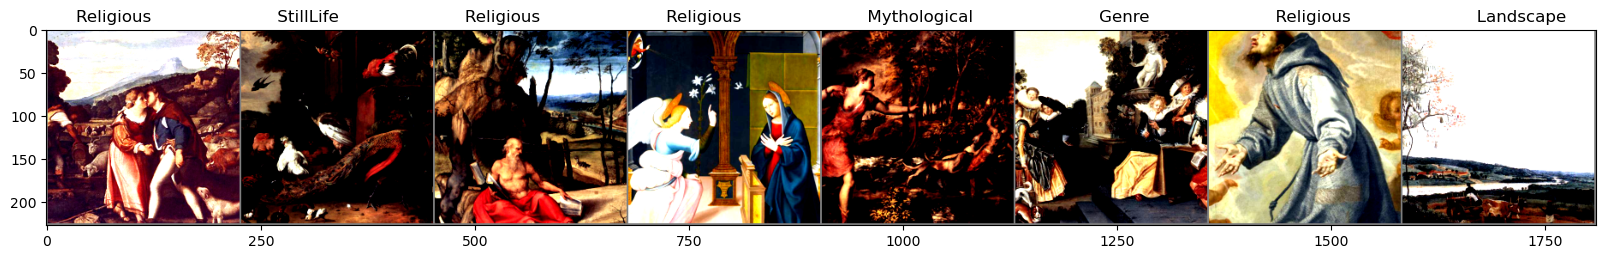

In [6]:
def imshow(imageBatch):
    images, labels = imageBatch
    img =  torchvision.utils.make_grid(images)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.rcParams["figure.figsize"] = (20,3)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('                        '.join(f'{class_names[labels[j]]:5s}' for j in range(len(labels))))
    plt.show()

# show images
imshow(iter(dataloaders['train']).next())

## Train

In [7]:
num_classes = len(class_names)

# Loading the pretrained models
model_ft = models.resnet18(pretrained=True)
# Modify fully connected layers to match num_classes
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs,num_classes),
    nn.Sigmoid()
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
#summary of the models
from torchsummary import summary
print('Model Summary:-\n')
for num, (name, param) in enumerate(model_ft.named_parameters()):
    print(num, name, param.requires_grad )
summary(model_ft, input_size=(3, 224, 224))
print(model_ft)
model_ft = model_ft.to(device)

Model Summary:-

0 conv1.weight True
1 bn1.weight True
2 bn1.bias True
3 layer1.0.conv1.weight True
4 layer1.0.bn1.weight True
5 layer1.0.bn1.bias True
6 layer1.0.conv2.weight True
7 layer1.0.bn2.weight True
8 layer1.0.bn2.bias True
9 layer1.1.conv1.weight True
10 layer1.1.bn1.weight True
11 layer1.1.bn1.bias True
12 layer1.1.conv2.weight True
13 layer1.1.bn2.weight True
14 layer1.1.bn2.bias True
15 layer2.0.conv1.weight True
16 layer2.0.bn1.weight True
17 layer2.0.bn1.bias True
18 layer2.0.conv2.weight True
19 layer2.0.bn2.weight True
20 layer2.0.bn2.bias True
21 layer2.0.downsample.0.weight True
22 layer2.0.downsample.1.weight True
23 layer2.0.downsample.1.bias True
24 layer2.1.conv1.weight True
25 layer2.1.bn1.weight True
26 layer2.1.bn1.bias True
27 layer2.1.conv2.weight True
28 layer2.1.bn2.weight True
29 layer2.1.bn2.bias True
30 layer3.0.conv1.weight True
31 layer3.0.bn1.weight True
32 layer3.0.bn1.bias True
33 layer3.0.conv2.weight True
34 layer3.0.bn2.weight True
35 layer3.0.b

In [9]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer 
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Learning rate decay
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Tensorboard summary
    writer = SummaryWriter()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Record training loss and accuracy for each phase
            if phase == 'train':
                writer.add_scalar('Train/Loss', epoch_loss, epoch)
                writer.add_scalar('Train/Accuracy', epoch_acc, epoch)
                writer.flush()
            else:
                writer.add_scalar('Valid/Loss', epoch_loss, epoch)
                writer.add_scalar('Valid/Accuracy', epoch_acc, epoch)
                writer.flush()

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
print("Training:-\n")
torch.set_num_threads(12)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Training:-

Epoch 0/29
----------
train Loss: 1.7183 Acc: 0.5087
valid Loss: 1.6389 Acc: 0.6868

Epoch 1/29
----------
train Loss: 1.6338 Acc: 0.6797
valid Loss: 1.5886 Acc: 0.7502

Epoch 2/29
----------
train Loss: 1.6022 Acc: 0.7171
valid Loss: 1.5747 Acc: 0.7570

Epoch 3/29
----------
train Loss: 1.5780 Acc: 0.7432
valid Loss: 1.5614 Acc: 0.7627

Epoch 4/29
----------
train Loss: 1.5580 Acc: 0.7647
valid Loss: 1.5633 Acc: 0.7685

Epoch 5/29
----------
train Loss: 1.5433 Acc: 0.7823
valid Loss: 1.5616 Acc: 0.7743

Epoch 6/29
----------
train Loss: 1.5274 Acc: 0.8036
valid Loss: 1.5659 Acc: 0.7781

Epoch 7/29
----------
train Loss: 1.5090 Acc: 0.8326
valid Loss: 1.5645 Acc: 0.7771

Epoch 8/29
----------
train Loss: 1.5034 Acc: 0.8381
valid Loss: 1.5648 Acc: 0.7733

Epoch 9/29
----------
train Loss: 1.5004 Acc: 0.8439
valid Loss: 1.5631 Acc: 0.7781

Epoch 10/29
----------
train Loss: 1.4998 Acc: 0.8458
valid Loss: 1.5655 Acc: 0.7733

Epoch 11/29
----------
train Loss: 1.4959 Acc: 0.850

In [12]:
model_path = "trained/model.pth" 
print("\nSaving the model...")
torch.save(model_ft, model_path)


Saving the model...


## Evaluating 

In [14]:
from sklearn.metrics import confusion_matrix

bs = 1
EVAL_DIR='rawdata/art/types/test'

model = torch.load(model_path)
model.eval()


# Prepare the eval data loader
eval_transform=transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

eval_dataset=datasets.ImageFolder(root=EVAL_DIR, transform=eval_transform)
eval_loader=data.DataLoader(eval_dataset, batch_size=bs, shuffle=False, pin_memory=True)

# Enable gpu mode, if cuda available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of classes and dataset-size
num_classes=len(eval_dataset.classes)
dsize=len(eval_dataset)

# Class label names
# Class names or target labels
class_names = eval_dataset.classes
print("Classes:", class_names)

# Initialize the prediction and label lists
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

# Evaluate the model accuracy on the dataset
correct = 0
total = 0
with torch.no_grad():
    for images, labels in eval_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

# Overall accuracy
overall_accuracy=100 * correct / total
print('Accuracy of the network on the {:d} test images: {:.2f}%'.format(dsize, 
    overall_accuracy))

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print('Confusion Matrix')
print('-'*16)
print(conf_mat,'\n')

Classes: ['Genre', 'Historical', 'Interior', 'Landscape', 'Mythological', 'Portrait', 'Religious', 'StillLife', 'Study']
Accuracy of the network on the 1041 test images: 78.58%
Confusion Matrix
----------------
[[ 59   0   0   9   6   8   6   1   0]
 [  7   0   0   7   5   1  20   0   0]
 [  3   0   0   1   1   0  16   0   0]
 [  4   0   0 152   3   0   3   0   0]
 [  5   0   0   1  42   3  39   1   0]
 [ 12   0   0   3   1 156   5   1   0]
 [ 12   0   0   6  13  13 360   1   0]
 [  1   0   0   0   0   0   3  49   0]
 [  0   0   0   0   0   1   0   1   0]] 



## Creating CSV with results 

In [18]:
bs = 1
model = torch.load(model_path)
model.eval()

# Prepare the eval data loader
eval_transform=transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

def append_results(file, images_path): 
    eval_dataset=datasets.ImageFolder(root=images_path, transform=eval_transform)
    eval_loader=data.DataLoader(eval_dataset, batch_size=bs, shuffle=False, pin_memory=True)
    
    with torch.no_grad():    
        for i, (images, labels) in enumerate(eval_loader, 0):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            file.write(eval_loader.dataset.samples[i][0] + ',' + ','.join(["{:.4f}".format(round(x, 4)) for x in outputs.data[0].detach().numpy()])+ ',' + class_names[labels.numpy()[0]] + ',' + class_names[predicted.numpy()[0]] + '\n')


file = open('results.csv', 'w')
file.write('FILE,' + ','.join(["w(" + obj +  ")" for obj in class_names]) + ',EXPECTED,PREDICTED\n')
append_results(file, 'rawdata/art/types/test');
append_results(file, 'rawdata/art/types/train'); 
file.close()


## Analyzing CSV results

In [75]:
results = pd.read_csv('results.csv').rename(columns={"EXPECTED": "Class"})

weights = results[['w(Genre)', 'w(Historical)', 'w(Interior)', 'w(Landscape)', 'w(Mythological)', 'w(Portrait)', 'w(Religious)', 'w(StillLife)', 'w(Study)']]
results['Max'] = weights.max(axis=1)
results['Predicted Count'] = results.where(weights > 0.7).count(axis=1)
results['Neighbors Count'] = results.where(weights.sub(results['Max'] - 0.1, axis=0) > 0).count(axis=1) - 1


print("Single predicted per class")
print(results.where(results['Predicted Count'] == 1).groupby(by=["Class"]).size())

print()

print("Neighbors per class")
print(results.where(results['Neighbors Count'] > 0).groupby(by=["Class"]).size())


Single predicted per class
Class
Genre           1398
Historical       447
Interior         286
Landscape       2555
Mythological     377
Portrait        3247
Religious       7126
StillLife        965
Study             42
dtype: int64

Neighbors per class
Class
Genre            197
Historical        68
Interior          68
Landscape         49
Mythological    1385
Portrait         117
Religious        521
StillLife          5
Study             12
dtype: int64
